In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym

In [2]:

class Net(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden):
        super(Net, self).__init__()

        # 輸入層 (state) 到隱藏層，隱藏層到輸出層 (action)
        self.fc1 = nn.Linear(n_states, n_hidden)
        self.out = nn.Linear(n_hidden, n_actions)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x) # ReLU activation
        actions_value = self.out(x)
        return actions_value

In [3]:
class DQN(object):
    def __init__(self, n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity):
        self.eval_net, self.target_net = Net(n_states, n_actions, n_hidden), Net(n_states, n_actions, n_hidden)

        self.memory = np.zeros((memory_capacity, n_states * 2 + 2)) # 每個 memory 中的 experience 大小為 (state + next state + reward + action)
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=lr)
        self.loss_func = nn.MSELoss()
        self.memory_counter = 0
        self.learn_step_counter = 0 # 讓 target network 知道什麼時候要更新

        self.n_states = n_states
        self.n_actions = n_actions
        self.n_hidden = n_hidden
        self.batch_size = batch_size
        self.lr = lr
        self.epsilon = epsilon
        self.gamma = gamma
        self.target_replace_iter = target_replace_iter
        self.memory_capacity = memory_capacity
        
    def choose_action(self, state):
        x = torch.unsqueeze(torch.FloatTensor(state), 0)

        # epsilon-greedy
        if np.random.uniform() < self.epsilon: # 隨機
            action = np.random.randint(0, self.n_actions)
        else: # 根據現有 policy 做最好的選擇
            actions_value = self.eval_net(x) # 以現有 eval net 得出各個 action 的分數
            action = torch.max(actions_value, 1)[1].data.numpy()[0] # 挑選最高分的 action

        return action


    def store_transition(self, state, action, reward, next_state):
        # 打包 experience
        transition = np.hstack((state, [action, reward], next_state))

        # 存進 memory；舊 memory 可能會被覆蓋
        index = self.memory_counter % self.memory_capacity
        self.memory[index, :] = transition
        self.memory_counter += 1
        
        
    def learn(self):
        # 隨機取樣 batch_size 個 experience
        sample_index = np.random.choice(self.memory_capacity, self.batch_size)
        b_memory = self.memory[sample_index, :]
        b_state = torch.FloatTensor(b_memory[:, :self.n_states])
        b_action = torch.LongTensor(b_memory[:, self.n_states:self.n_states+1].astype(int))
        b_reward = torch.FloatTensor(b_memory[:, self.n_states+1:self.n_states+2])
        b_next_state = torch.FloatTensor(b_memory[:, -self.n_states:])

        # 計算現有 eval net 和 target net 得出 Q value 的落差
        q_eval = self.eval_net(b_state).gather(1, b_action) # 重新計算這些 experience 當下 eval net 所得出的 Q value
        q_next = self.target_net(b_next_state).detach() # detach 才不會訓練到 target net
        q_target = b_reward + self.gamma * q_next.max(1)[0].view(self.batch_size, 1) # 計算這些 experience 當下 target net 所得出的 Q value
        loss = self.loss_func(q_eval, q_target)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 每隔一段時間 (target_replace_iter), 更新 target net，即複製 eval net 到 target net
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_replace_iter == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())

In [4]:
env = gym.make('CartPole-v1')

# Environment parameters
n_actions = env.action_space.n
n_states = env.observation_space.shape[0]

n_hidden = 50
batch_size = 32
lr = 0.01                 # learning rate
epsilon = 0.1             # epsilon-greedy
gamma = 0.9               # reward discount factor
target_replace_iter = 5 # target network 更新間隔
memory_capacity = 25
n_episodes = 100

dqn = DQN(n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity)

In [5]:

time_step = np.zeros(n_episodes)

for i_episode in range(n_episodes):
    
    t = 0
    rewards = 0
    state, _= env.reset()
    while True:
        env.render()

        # 選擇 action
        action = dqn.choose_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        
        done = terminated or truncated
            
            
        x, v, theta, omega = next_state
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8 # 小車離中間越近越好
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5 # 柱子越正越好
        reward = r1 + r2
        
        # 儲存 experience
        dqn.store_transition(state, action, reward, next_state)

        # 累積 reward
        rewards += reward

        # 有足夠 experience 後進行訓練
        if dqn.memory_counter > memory_capacity:
            dqn.learn()

        # 進入下一 state
        state = next_state

        if done:
            
            if i_episode % 5 == 0:
                print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            
            if i_episode == 20:
                torch.save(dqn.eval_net.state_dict(), 'dqn_eval_net_v2_20.pth')
            
            if i_episode == 30:
                torch.save(dqn.eval_net.state_dict(), 'dqn_eval_net_v2_30.pth')
                
            if i_episode == 40:
                torch.save(dqn.eval_net.state_dict(), 'dqn_eval_net_v2_40.pth')
                
            if i_episode == 50:
                torch.save(dqn.eval_net.state_dict(), 'dqn_eval_net_v2_50.pth')
                
            time_step[i_episode] = t+1
            break

        t += 1

env.close()

/Users/xiemengxin/anaconda3/lib/python3.10/site-packages/gym/envs/classic_control/cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


Episode finished after 8 timesteps, total rewards 1.3593107086625742
Episode finished after 9 timesteps, total rewards 1.2242881180847711
Episode finished after 10 timesteps, total rewards 2.784688290528207
Episode finished after 23 timesteps, total rewards 9.209245370715593
Episode finished after 12 timesteps, total rewards 1.608026580316741
Episode finished after 24 timesteps, total rewards 2.775160055378845
Episode finished after 97 timesteps, total rewards 27.35037752475282
Episode finished after 131 timesteps, total rewards 31.027589181335067
Episode finished after 418 timesteps, total rewards 146.55699606328756
Episode finished after 500 timesteps, total rewards 173.1981121476633
Episode finished after 500 timesteps, total rewards 276.72878174760655
Episode finished after 500 timesteps, total rewards 294.00359356769206
Episode finished after 500 timesteps, total rewards 285.73622192250764
Episode finished after 500 timesteps, total rewards 211.47256456375683
Episode finished afte

In [6]:
torch.save(dqn.eval_net.state_dict(), 'dqn_eval_net_v2.pth')
torch.save(dqn.target_net.state_dict(), 'dqn_target_net_v2.pth')

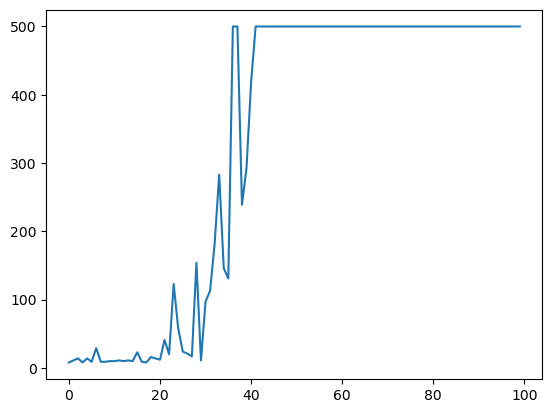

In [7]:
import matplotlib.pyplot as plt

plt.plot(time_step)
plt.savefig('time_step_v2.png')

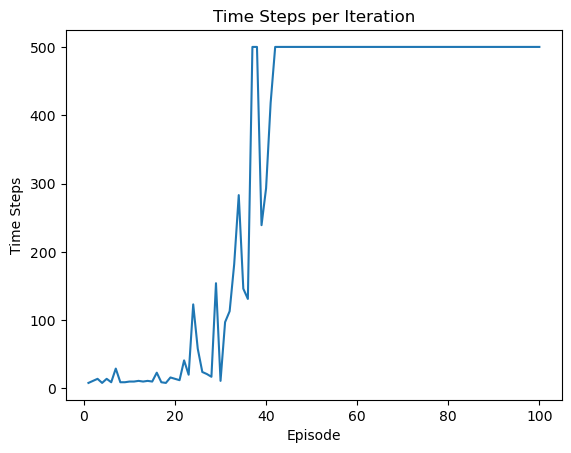

In [8]:
iterations = list(range(1, len(time_step) + 1))
plt.plot(iterations, time_step)
plt.xlabel('Episode')
plt.ylabel('Time Steps')
plt.title('Time Steps per Iteration')
plt.savefig('time_step_v1.png')
plt.show()